# Introduction

### Business Problem

A venture capitalist has seen the recent housing boom in Atlanta, Georgia and is looking to start a small business in whichever areas have seen pronounced value increase. One assumption this venture capitalist is making, wherever he starts his business will see an increase in public spending as long as it is in a heavily gentrified area. This person is looking to do some initial research to identify those areas in Atlanta that have the highest percentage increase in home value. The capitalist is hoping to start a business while business zoned property is still relatively cheap, In order that in 10 years, a large profit can be made when selling. However, this person does not want to compete in a saturated market. Ideally, this initial data would lead into possible ideas and identify what types of business would add the most value to the local neighborhood.


### Data Used

For this assignment I will be using two data sources. One will be Foursquare venue data pulled from Folium geolocation points, after identifying those zip codes which have been most affected by the housing boom. The second data set will be pulled from Zillow housing research for average home prices. This data will be filtered to include all of Atlanta. It will need to be historical data, starting after the 2009 housing market crash. Ideally, we would have month by month value for each zip code.


# Methodology and Analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import requests
import folium
import time
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly.io as pio
import json


### Reading data from zillow

In [2]:
df = pd.read_csv('fulton_home_value.csv')
df.head()

RegionID  SizeRank  RegionName RegionType StateName State         City  \
0     71038       162       30318        Zip        GA    GA      Atlanta   
1     71050       262       30331        Zip        GA    GA      Atlanta   
2     70808       301       30022        Zip        GA    GA  Johns Creek   
3     70791       302       30004        Zip        GA    GA       Milton   
4     70854       602       30075        Zip        GA    GA      Roswell   

                           Metro     CountyName  3/31/2013  ...  6/30/2019  \
0  Atlanta-Sandy Springs-Roswell  Fulton County     118936  ...     255294   
1  Atlanta-Sandy Springs-Roswell  Fulton County      91606  ...     174756   
2  Atlanta-Sandy Springs-Roswell  Fulton County     314143  ...     432271   
3  Atlanta-Sandy Springs-Roswell  Fulton County     321086  ...     454907   
4  Atlanta-Sandy Springs-Roswell  Fulton County     315211  ...     446155   

   7/31/2019  8/31/2019  9/30/2019  10/31/2019  11/30/2019  12/31/2019  \
0     256222     257309     258140      258806      259562      261119   
1     175331     176303     177152      177879      178782      180166   
2     432146     431872     431638      431648      432207      433749   
3     455490     456018     456317      456493      457159      458781   
4     446312     446489     446915      446843      446616      447157   

   1/31/2020  2/29/2020  3/31/2020  
0     262960     265523     267538  
1     182066     184377     186278  
2     434649     436290     437304  
3     460420     462150     463781  
4     447829     449612     450374  

[5 rows x 94 columns]

In [3]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '3/31/2013', '4/30/2013',
       '5/31/2013', '6/30/2013', '7/31/2013', '8/31/2013', '9/30/2013',
       '10/31/2013', '11/30/2013', '12/31/2013', '1/31/2014', '2/28/2014',
       '3/31/2014', '4/30/2014', '5/31/2014', '6/30/2014', '7/31/2014',
       '8/31/2014', '9/30/2014', '10/31/2014', '11/30/2014', '12/31/2014',
       '1/31/2015', '2/28/2015', '3/31/2015', '4/30/2015', '5/31/2015',
       '6/30/2015', '7/31/2015', '8/31/2015', '9/30/2015', '10/31/2015',
       '11/30/2015', '12/31/2015', '1/31/2016', '2/29/2016', '3/31/2016',
       '4/30/2016', '5/31/2016', '6/30/2016', '7/31/2016', '8/31/2016',
       '9/30/2016', '10/31/2016', '11/30/2016', '12/31/2016', '1/31/2017',
       '2/28/2017', '3/31/2017', '4/30/2017', '5/31/2017', '6/30/2017',
       '7/31/2017', '8/31/2017', '9/30/2017', '10/31/2017', '11/30/2017',
       '12/31/2017', '1/31/2018', '2/28/2018', '3

In [4]:
df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'], axis =1, inplace = True)

In [5]:
df.set_index('RegionName', inplace = True)

### Transpose to create line graphs

In [6]:
df_trans = df.T.reset_index()
df_trans = df_trans.rename(columns={'index': 'Date'})

In [7]:
df_trans.Date = pd.to_datetime(df_trans.Date)

In [8]:
new_col = {}
for i in df_trans.columns[1:37]:
    new_col[i] = '{}'.format(i)

df_trans = df_trans.rename(columns = new_col)

In [9]:
data = []
tracex = []
zipcodes = list(df_trans.iloc[:,1:37])

for i in range(0, len(zipcodes)):
    tracex = go.Scatter(
        x = df_trans['Date'],
        y = df_trans[zipcodes[i]],
        mode = 'lines',
        name = zipcodes[i] )
    data.append(tracex)
    
fig = go.Figure(data = data)
fig.update_xaxes(title = '<b>Year</b>')
fig.update_yaxes(title = '<b>Average House Price in $</b>')
fig.update_layout(height = 600, width = 1200)

fig.show()
    

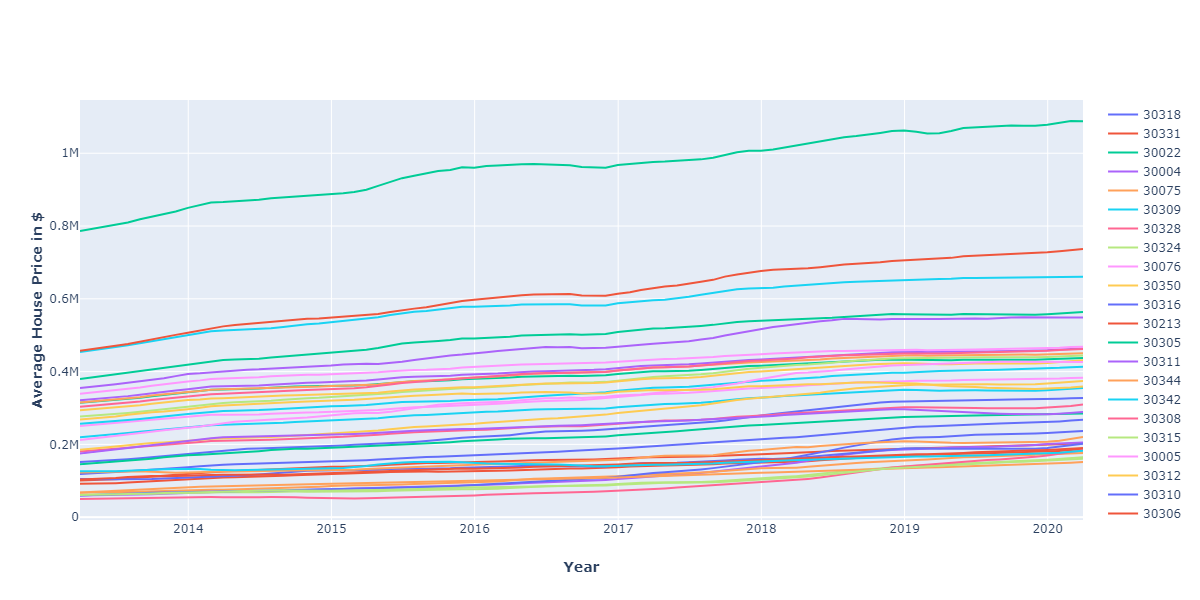

### Using applymap to look at Percentage Change

In [10]:
df_pct = df_trans.iloc[:,1:37].pct_change()
df_pct = df_pct.applymap(lambda x: x * 100)


In [64]:
df_pct['Date'] = df_trans.Date
df_pct.head()

RegionName     30318     30331     30022     30004     30075     30309  \
0                NaN       NaN       NaN       NaN       NaN       NaN   
1           0.997175  0.330764  0.780536  0.814424  0.907329  1.120733   
2           1.595045  0.592978  0.859142  0.842444  1.027129  1.382798   
3           1.450368  1.026456  0.683338  0.854093  0.657874  1.281692   
4           1.647713  1.899297  0.924736  1.023644  0.813104  1.535862   

RegionName     30328     30324     30076     30350  ...     30354     30317  \
0                NaN       NaN       NaN       NaN  ...       NaN       NaN   
1           0.833885  0.696903  1.009980  0.893980  ...  0.640594  1.824854   
2           0.879247  0.886896  1.217901  0.933671  ...  0.481468  2.319987   
3           0.710347  0.769567  0.967523  0.752740  ...  0.644836  1.643458   
4           0.949665  1.025194  1.022135  0.927420  ...  0.952181  1.527923   

RegionName     30326     30337     30268     30313     30363     30303  \
0                NaN       NaN       NaN       NaN       NaN       NaN   
1           0.850237  0.688185  0.689855  1.622379  1.895905  0.424715   
2           0.984811 -1.216653  0.918608  2.133371  1.904383  0.981949   
3           1.142980 -0.103354  1.827129  1.785584  2.282736  0.625000   
4           1.642514 -0.592986  2.591417  1.255366  2.268923  0.754272   

RegionName     30336       Date  
0                NaN 2013-03-31  
1          -0.065020 2013-04-30  
2          -0.458606 2013-05-31  
3           0.634485 2013-06-30  
4           1.257010 2013-07-31  

[5 rows x 37 columns]

In [12]:
df_pct.columns.shape

(37,)

In [13]:
data = []
tracex = []
zipcodes = list(df_pct.iloc[:,0:36])

for i in range(0, len(zipcodes)):
    tracex = go.Scatter(
        x = df_pct['Date'],
        y = df_pct[zipcodes[i]],
        mode = 'lines',
        name = '{}'.format(zipcodes[i]))
    data.append(tracex)
    
fig = go.Figure(data = data)
fig.update_xaxes(title = '<b>Year</b>')
fig.update_yaxes(title = '<b>Percent Change</b>')
fig.update_layout(height = 600, width = 1200)

fig.show()

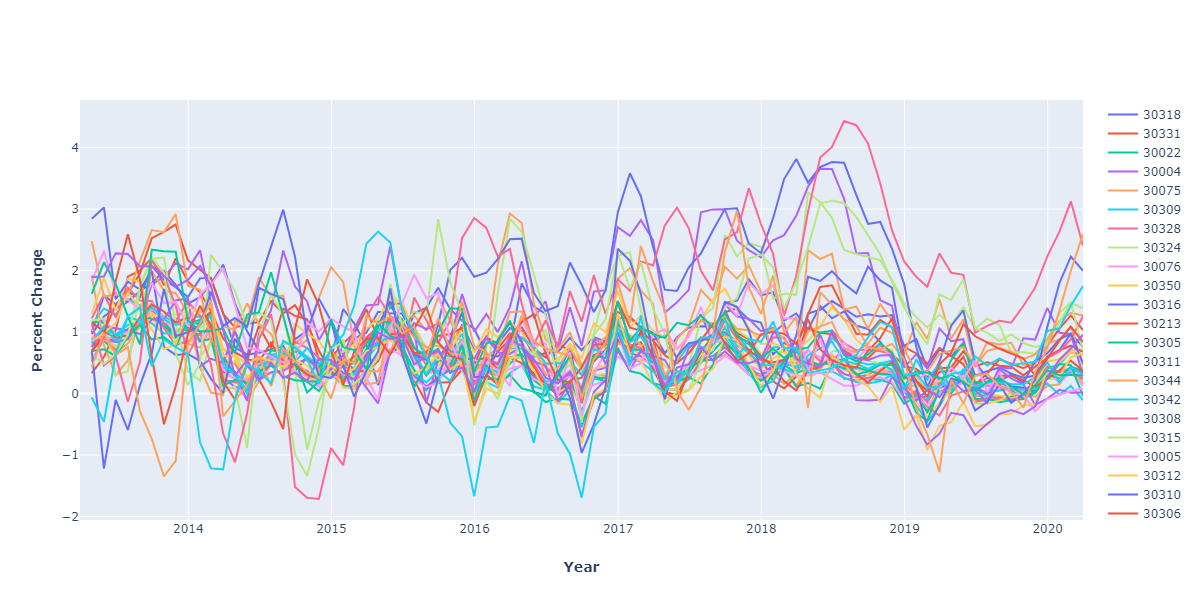

### Sorting and looking at Top 10 in Atlanta zip codes

In [14]:
top_ten = [i for i in df_pct.sum().sort_values(ascending = False)[0:10].keys()]

In [15]:
top_ten

['30310',
 '30314',
 '30311',
 '30315',
 '30344',
 '30354',
 '30318',
 '30291',
 '30316',
 '30331']

In [16]:
top_ten.insert(0,'Date')

top_ten

['Date',
 '30310',
 '30314',
 '30311',
 '30315',
 '30344',
 '30354',
 '30318',
 '30291',
 '30316',
 '30331']

In [17]:
df_pct_top = df_pct.loc[:,top_ten]
df_pct_top

RegionName       Date     30310     30314     30311     30315     30344  \
0          2013-03-31       NaN       NaN       NaN       NaN       NaN   
1          2013-04-30  2.843794  1.135749  0.522308  1.188673  1.920779   
2          2013-05-31  3.025930  0.453555  0.900070  1.218639  0.785486   
3          2013-06-30  1.533000  0.609239  0.833901  0.305412  0.300986   
4          2013-07-31  1.818723 -0.133260  0.881369  0.357366  0.537829   
..                ...       ...       ...       ...       ...       ...   
80         2019-11-30  0.531485  1.721968  0.877729  0.644817  0.476999   
81         2019-12-31  0.656496  2.231141  1.392450  0.837623  0.807399   
82         2020-01-31  0.881137  2.632278  0.987561  1.308139  0.877488   
83         2020-02-29  0.975771  3.126150  0.968539  1.483401  1.092924   
84         2020-03-31  0.491015  2.403355  0.293388  1.380306  0.448708   

RegionName     30354     30318     30291     30316     30331  
0                NaN       NaN       NaN       NaN       NaN  
1           0.640594  0.997175  2.478154  0.966876  0.330764  
2           0.481468  1.595045  1.577041  1.253477  0.592978  
3           0.644836  1.450368  1.610795  1.387291  1.026456  
4           0.952181  1.647713  1.595046  1.495192  1.899297  
..               ...       ...       ...       ...       ...  
80          0.755570  0.292111  0.637275  0.028454  0.507648  
81          0.793480  0.599857  0.892481  0.290023  0.774127  
82          1.157621  0.705043  1.180590  0.294425  1.054583  
83          1.479265  0.974673  1.313090  0.358421  1.269320  
84          0.693964  0.758880  1.266660  0.377969  1.031040  

[85 rows x 11 columns]

In [18]:
data = []
tracex = []
zipcodes = list(df_pct_top.iloc[:,1:len(top_ten)])

for i in range(0, len(zipcodes)):
    tracex = go.Scatter(
        x = df_pct_top['Date'],
        y = df_pct_top[zipcodes[i]],
        mode = 'lines',
        name = '{}'.format(zipcodes[i]))
    data.append(tracex)
    
fig = go.Figure(data = data)
fig.update_xaxes(title = '<b>Year</b>')
fig.update_yaxes(title = '<b>Percent Change</b>')
fig.update_layout(height = 600, width = 1200)

fig.show()

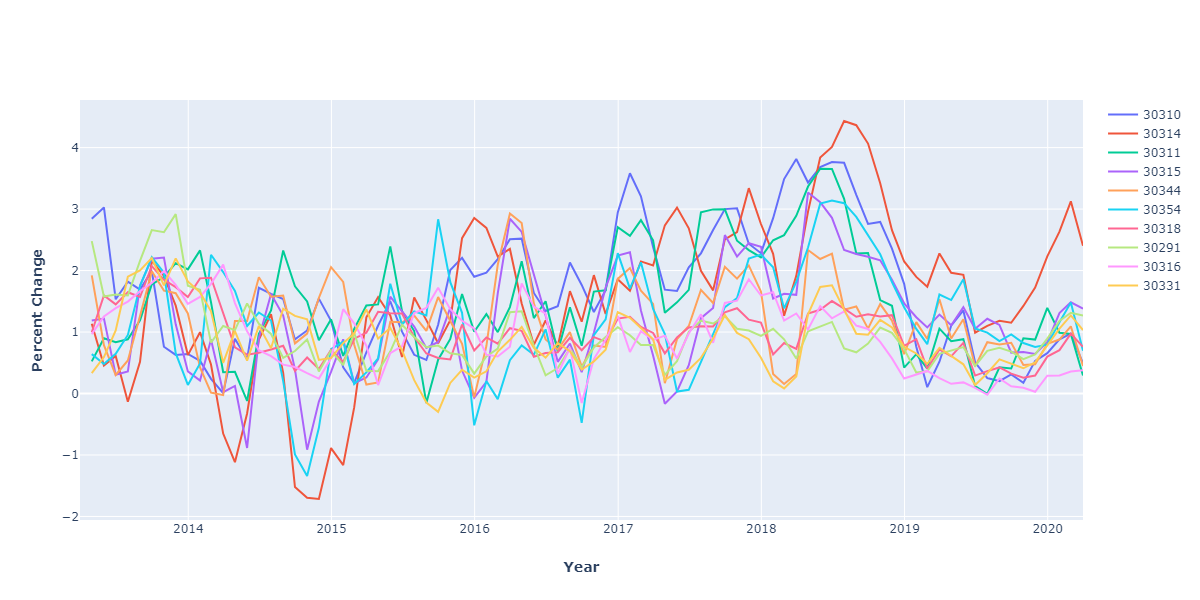

In [19]:
df_trans_top = df_trans.loc[:,top_ten]

In [20]:
df_trans_top.Date

0    2013-03-31
1    2013-04-30
2    2013-05-31
3    2013-06-30
4    2013-07-31
        ...    
80   2019-11-30
81   2019-12-31
82   2020-01-31
83   2020-02-29
84   2020-03-31
Name: Date, Length: 85, dtype: datetime64[ns]

In [21]:
data = []
tracex = []
zipcodes = list(df_trans_top.iloc[:,1:len(top_ten)])

for i in range(0, len(zipcodes)):
    tracex = go.Scatter(
        x = df_trans_top['Date'],
        y = df_trans_top[zipcodes[i]],
        mode = 'lines',
        name = '{}'.format(zipcodes[i]))
    data.append(tracex)
    
fig = go.Figure(data = data)
fig.update_xaxes(title = '<b>Year</b>')
fig.update_yaxes(title = '<b>Average House Price in $</b>')
fig.update_layout(height = 600, width = 1200,
                 shapes=
        # 1st highlight during Feb 4 - Feb 6
        [dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="paper",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=.65,
            y0=0,
            x1=.84,
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )])
                 

fig.show()

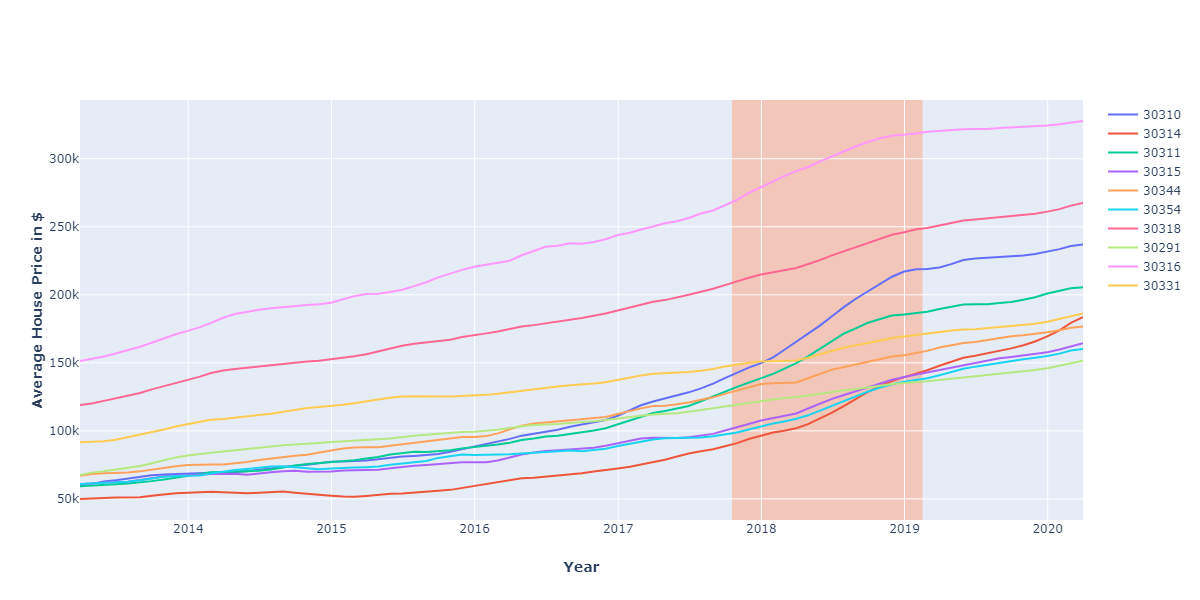






### Next, we are getting the geolocation coordinates of these zip codes

In [22]:
addresses = top_ten[1:6]

zipc = []
long = []
lat = []

for i in addresses:
    geolocator = Nominatim(user_agent="peter")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude
    long.append(longitude)
    lat.append(latitude)
    zipc.append(i)

    
time.sleep(4)

addresses = top_ten[6:11]   
for i in addresses:
    geolocator = Nominatim(user_agent="peter")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude
    long.append(longitude)
    lat.append(latitude)
    zipc.append(i)
        


In [23]:
#atl_coord = pd.DataFrame(columns=['Zipcode', 'Latitude', 'Longitude'])
#atl_coord.Zipcode = zipc
#atl_coord.Latitude = lat
#atl_coord.Longitude = long

#atl_coord.to_csv('atl_coord.csv', index = False)
atl_coord = pd.read_csv('atl_coord.csv')
atl_coord.head()

Zipcode   Latitude  Longitude
0    30310  33.745139 -84.427804
1    30314  33.750838 -84.445932
2    30311  33.723504 -84.470770
3    30315  33.734978 -84.383185
4    30344  33.706159 -84.457296

In [24]:
address = 'Atlanta, Georgia'

geolocator = Nominatim(user_agent="pete")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Atlanta are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Atlanta are 33.7490987, -84.3901849.


### Plotting these coordinates

In [25]:
map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=10)

for latitude, longitude, zipcode in zip(atl_coord.Latitude, atl_coord.Longitude, atl_coord.Zipcode):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)

map_atlanta

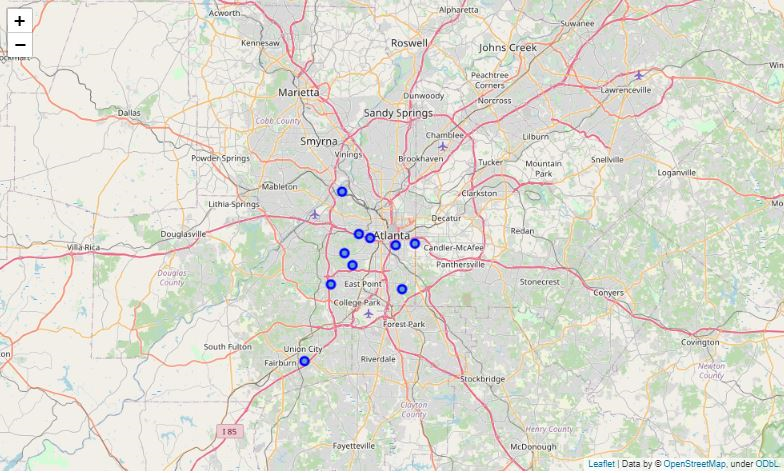

<br />
<br />
<br />
<br />
<br />
<br />
<br />

### Starting on Foursquare API

In [27]:
CLIENT_ID = 'CCBMXEF4ITVUNF0RDKXYHAMX5F55TLG3DCMYIE3DH44AQBCY' # your Foursquare ID
CLIENT_SECRET = 'UXRV1ZBEKD1DCQZIZIDC3L1YMHNNWQIVZC4XVISBTKKZAKTW' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CCBMXEF4ITVUNF0RDKXYHAMX5F55TLG3DCMYIE3DH44AQBCY
CLIENT_SECRET:UXRV1ZBEKD1DCQZIZIDC3L1YMHNNWQIVZC4XVISBTKKZAKTW


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<br />
<br />
<br />

###  Getting venues near these zip codes

In [29]:
atl_venues = getNearbyVenues(names= atl_coord.Zipcode,
                                   latitudes= atl_coord.Latitude,
                                   longitudes= atl_coord.Longitude
                                  )


30310
30314
30311
30315
30344
30354
30318
30291
30316
30331


In [30]:
#atl_venues.to_csv('atl_venues.csv', index = False)
atl_venues = pd.read_csv('atl_venues.csv')
atl_venues.head()

Unnamed: 0  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0         30310              33.745139              -84.427804   
1           1         30310              33.745139              -84.427804   
2           2         30310              33.745139              -84.427804   
3           3         30310              33.745139              -84.427804   
4           4         30310              33.745139              -84.427804   

                                               Venue  Venue Latitude  \
0                                      West End Park       33.741926   
1                              Tassili's Raw Reality       33.738453   
2                                   Lean Draft House       33.738184   
3  Ray Charles Performing Arts Center - Morehouse...       33.744034   
4                 Atlanta BeltLine Corridor over MLK       33.750790   

   Venue Longitude                 Venue Category  
0       -84.424973                           Park  
1       -84.422394  Vegetarian / Vegan Restaurant  
2       -84.430623                       Beer Bar  
3       -84.416824                   Concert Hall  
4       -84.426363                          Trail

In [31]:
print('There are {} uniques categories.'.format(len(atl_venues['Venue Category'].unique())))

There are 103 uniques categories.


In [32]:

atl_onehot = pd.get_dummies(atl_venues[['Venue Category']], prefix="", prefix_sep="")


atl_onehot['Zipcode'] = atl_venues['Neighborhood'] 


atl_onehot.shape

(262, 104)

In [33]:
atl_grouped = atl_onehot.groupby('Zipcode').sum().reset_index()

In [34]:
atl_grouped.head()

Zipcode  Accessories Store  American Restaurant  Antique Shop  Art Museum  \
0    30291                  0                    1             0           0   
1    30310                  0                    0             0           1   
2    30311                  0                    1             0           0   
3    30314                  0                    0             0           0   
4    30315                  0                    0             0           0   

   Auto Dealership  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  ...  Tree  \
0                1                0          0           0       0  ...     0   
1                0                0          0           0       0  ...     0   
2                0                0          1           0       0  ...     0   
3                0                0          0           0       0  ...     0   
4                0                0          1           0       0  ...     0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 1            1   
1                              2                 0            0   
2                              0                 0            0   
3                              1                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  Zoo  Zoo Exhibit  
0                      0         0          0            0    0            0  
1                      0         0          0            0    0            0  
2                      0         0          0            0    0            0  
3                      0         0          0            0    0            0  
4                      0         1          0            0    1            4  

[5 rows x 104 columns]

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['Zipcode'] = atl_grouped['Zipcode']

for ind in np.arange(atl_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atl_grouped.iloc[ind, :], num_top_venues)

zipcode_venues_sorted.head()

Zipcode 1st Most Common Venue 2nd Most Common Venue  \
0    30291                  Bank     Mobile Phone Shop   
1    30310                 Trail                  Park   
2    30311              Pharmacy  Caribbean Restaurant   
3    30314                 Trail           Gas Station   
4    30315           Zoo Exhibit           Coffee Shop   

             3rd Most Common Venue          4th Most Common Venue  \
0                            Hotel                 Sandwich Place   
1  Southern / Soul Food Restaurant  Vegetarian / Vegan Restaurant   
2                      Dry Cleaner               Business Service   
3                             Park            Fried Chicken Joint   
4                          Brewery                   Burger Joint   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0  Fast Food Restaurant    Mexican Restaurant    Chinese Restaurant   
1           Pizza Place              Beer Bar          Tennis Court   
2                  Park    Seafood Restaurant        Discount Store   
3    Chinese Restaurant              Beer Bar              Pharmacy   
4           Pizza Place      Greek Restaurant            Beer Store   

  8th Most Common Venue          9th Most Common Venue 10th Most Common Venue  
0        Discount Store           Caribbean Restaurant     Seafood Restaurant  
1        Cosmetics Shop  Paper / Office Supplies Store             Donut Shop  
2  Fast Food Restaurant                Nature Preserve     Chinese Restaurant  
3              Cemetery                 Discount Store             Donut Shop  
4            Playground                      Pet Store                Parking

<br />
<br />
<br />

### Grouping top ten venues in all areas

In [37]:
atl_grouped['Zipcode'] = atl_grouped.Zipcode.astype(str)

num_top_venues = 10
venue = []
freq = []
zipcode = []


for hood in atl_grouped['Zipcode']:
    print("----"+hood+"----")
    temp = atl_grouped[atl_grouped['Zipcode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp['zipcode'] = hood
    g_data = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    for i in g_data.venue.values:
        venue.append(i)
    for i in g_data.freq.values:
        freq.append(i)
    for i in g_data.zipcode.values:
        zipcode.append(i)
    
   
    
top_ten_venues = pd.DataFrame()
top_ten_venues['Zipcode'] = zipcode
top_ten_venues['Venues'] = venue
top_ten_venues['Freq'] = freq


----30291----
----30310----
----30311----
----30314----
----30315----
----30316----
----30318----
----30331----
----30344----
----30354----


In [38]:
top_ten_venues.head()

Zipcode                Venues  Freq
0   30291                  Bank   3.0
1   30291  Fast Food Restaurant   2.0
2   30291                 Hotel   2.0
3   30291        Sandwich Place   2.0
4   30291     Mobile Phone Shop   2.0

In [39]:
top_ten_grouped = top_ten_venues.groupby('Venues')['Freq'].sum().sort_values(ascending = False).reset_index()
fig = px.bar(top_ten_grouped, x = 'Venues', y = 'Freq')

fig.update_layout(title = '<b>Highest Frequency Venues</b>', width = 1200)
fig.update_xaxes(title = '<b>Venues</b>',tickangle = 45)
fig.update_yaxes(title = '<b>Frequency</b>')

fig.show()

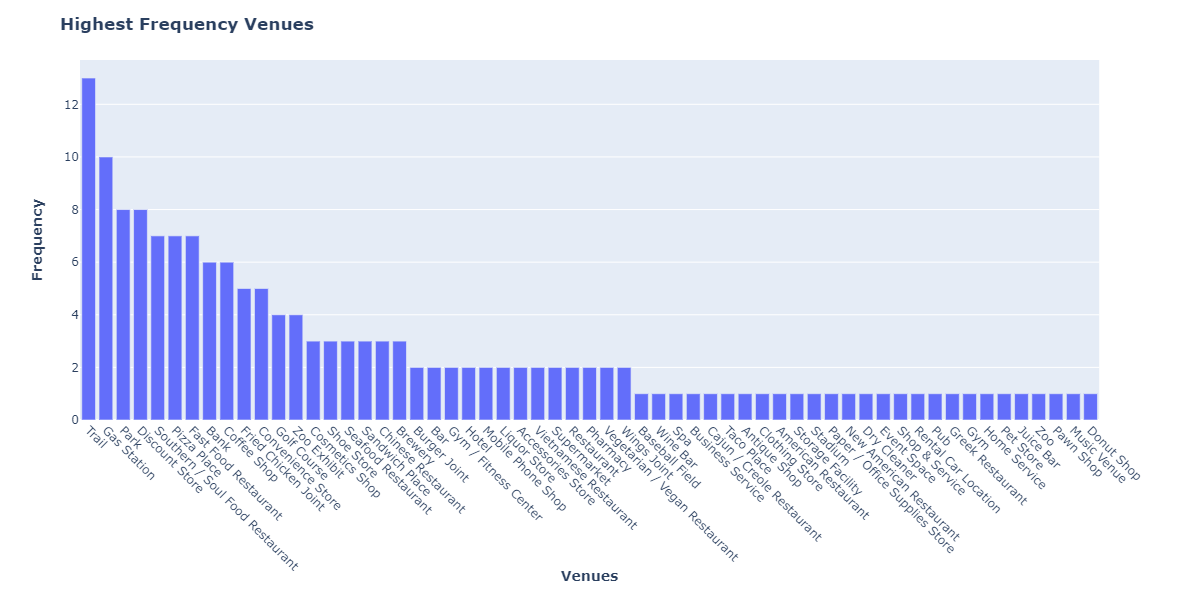

<br />
<br />
<br />

### Finding where these trails are and plotting the locations

In [40]:
trail_list = list(top_ten_venues[top_ten_venues.Venues == 'Trail'].Zipcode.values.astype(int))
trail_freq = list(top_ten_venues[top_ten_venues.Venues == 'Trail'].Freq.values)
trail_list

[30310, 30314, 30354]

In [41]:
trail_venues = top_ten_venues[top_ten_venues.Venues == 'Trail']
trail_venues

Zipcode Venues  Freq
10   30310  Trail   7.0
30   30314  Trail   5.0
90   30354  Trail   1.0

In [42]:
map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=10)



for latitude, longitude, zipcode in zip(atl_coord.Latitude, atl_coord.Longitude, atl_coord.Zipcode):
    if zipcode in trail_list:
        label = '{}'.format(zipcode)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [latitude, longitude],
            radius=5,
            popup=label,
            color= 'green',
            fill= True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(map_atlanta)
    else:
        label = '{}'.format(zipcode)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [latitude, longitude],
            radius=5,
            popup=label,
            color= 'red',
            fill= True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_atlanta)

map_atlanta

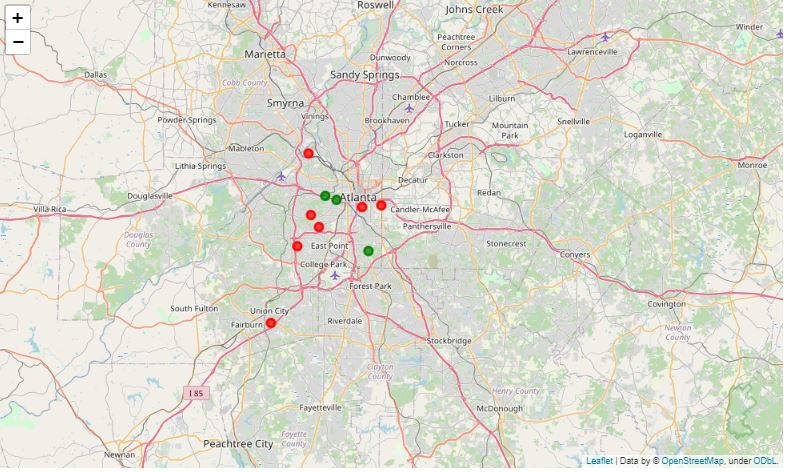

In [43]:
trails = atl_venues[atl_venues['Venue Category'] =='Trail']
trails

Unnamed: 0  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
4             4         30310              33.745139              -84.427804   
6             6         30310              33.745139              -84.427804   
7             7         30310              33.745139              -84.427804   
11           11         30310              33.745139              -84.427804   
20           20         30310              33.745139              -84.427804   
23           23         30310              33.745139              -84.427804   
27           27         30310              33.745139              -84.427804   
32           32         30314              33.750838              -84.445932   
34           34         30314              33.750838              -84.445932   
36           36         30314              33.750838              -84.445932   
37           37         30314              33.750838              -84.445932   
38           38         30314              33.750838              -84.445932   
142         142         30354              33.672086              -84.371992   
219         219         30316              33.736990              -84.350905   

                                                 Venue  Venue Latitude  \
4                   Atlanta BeltLine Corridor over MLK       33.750790   
6                Atlanta BeltLine Langhorn to Westview       33.750558   
7           Atlanta BeltLine Corridor under Lucile Ave       33.742318   
11   Atlanta BeltLine Corridor under Ralph David Ab...       33.739007   
20                Atlanta BeltLine Corridor at Lena St       33.756441   
23                Atlanta BeltLine Corridor under I-20       33.751341   
27              Atlanta BeltLine Corridor under Lawton       33.732403   
32                Atlanta BeltLine Corridor under I-20       33.751341   
34          Atlanta BeltLine Corridor under Lucile Ave       33.742318   
36                  Atlanta BeltLine Corridor over MLK       33.750790   
37               Atlanta BeltLine Langhorn to Westview       33.750558   
38   Atlanta BeltLine Corridor under Ralph David Ab...       33.739007   
142                            Southtowne Trail System       33.680929   
219        Atlanta BeltLine Corridor at Memorial Drive       33.743005   

     Venue Longitude Venue Category  
4         -84.426363          Trail  
6         -84.427511          Trail  
7         -84.433945          Trail  
11        -84.433123          Trail  
20        -84.424909          Trail  
23        -84.436525          Trail  
27        -84.423537          Trail  
32        -84.436525          Trail  
34        -84.433945          Trail  
36        -84.426363          Trail  
37        -84.427511          Trail  
38        -84.433123          Trail  
142       -84.369918          Trail  
219       -84.355474          Trail

In [44]:
map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=10)


for latitude, longitude, zipcode in zip(trails['Venue Latitude'], trails['Venue Longitude'], trails['Venue']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [latitude, longitude],
            radius=5,
            popup=label,
            color= 'red',
            fill= True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_atlanta)
 
map_atlanta

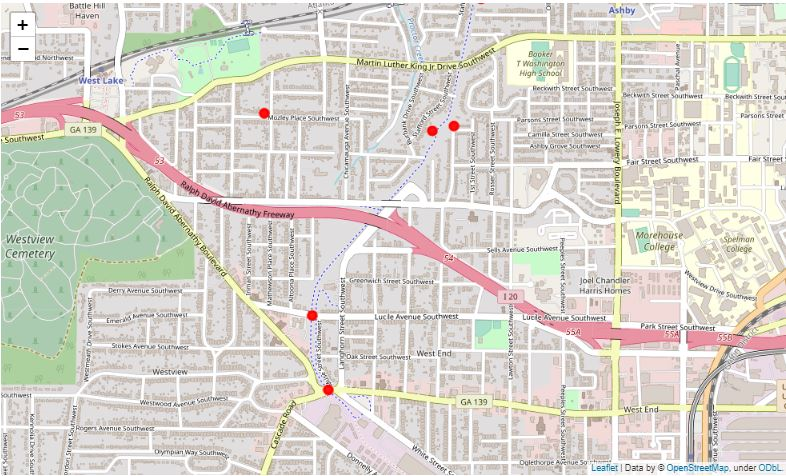

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />


### Starting comparison with Chicago, Dallas, and New York

In [45]:
six_oh_six = '1801 N California Ave, Chicago, IL'
white_rock = '8300 E Lawther Dr., Dallas, TX'
ernest = '511 W 22nd St., New York, NY 10011'

In [46]:
addresses = [six_oh_six, white_rock, ernest]

zipc = []
long = []
lat = []

for i in addresses:
    geolocator = Nominatim(user_agent="peter")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude
    long.append(longitude)
    lat.append(latitude)
    zipc.append(i)
    
developed_trails = pd.DataFrame(columns=['Zipcode', 'Latitude', 'Longitude'])
developed_trails.Zipcode = zipc
developed_trails.Latitude = lat
developed_trails.Longitude = long


In [47]:
developed_trails.head()

Zipcode   Latitude  Longitude
0  1801 N California Ave, Chicago, IL  41.914129 -87.696991
1      8300 E Lawther Dr., Dallas, TX  32.841340 -96.714399
2  511 W 22nd St., New York, NY 10011  40.747207 -74.004868

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### addresses used for locations

In [49]:
trail_venues = getNearbyVenues(names= developed_trails.Zipcode,
                                   latitudes= developed_trails.Latitude,
                                   longitudes= developed_trails.Longitude
                                  )


1801 N California Ave, Chicago, IL
8300 E Lawther Dr., Dallas, TX
511 W 22nd St., New York, NY 10011


In [50]:
trail_venues.head()

Neighborhood  Neighborhood Latitude  \
0  1801 N California Ave, Chicago, IL              41.914129   
1  1801 N California Ave, Chicago, IL              41.914129   
2  1801 N California Ave, Chicago, IL              41.914129   
3  1801 N California Ave, Chicago, IL              41.914129   
4  1801 N California Ave, Chicago, IL              41.914129   

   Neighborhood Longitude                       Venue  Venue Latitude  \
0              -87.696991     Table, Donkey and Stick       41.917657   
1              -87.696991        Middle Brow Bungalow       41.917664   
2              -87.696991            Twisted Scissors       41.917711   
3              -87.696991  Katherine Anne Confections       41.917475   
4              -87.696991         The 606  / Midpoint       41.913855   

   Venue Longitude           Venue Category  
0       -87.696074  New American Restaurant  
1       -87.698777                  Brewery  
2       -87.694103       Salon / Barbershop  
3       -87.696483             Dessert Shop  
4       -87.691507                    Trail

In [51]:

trail_onehot = pd.get_dummies(trail_venues[['Venue Category']], prefix="", prefix_sep="")


trail_onehot['Zipcode'] = trail_venues['Neighborhood'] 


trail_onehot.shape

(90, 60)

In [52]:
trail_grouped = trail_onehot.groupby('Zipcode').sum().reset_index()

trail_grouped['Zipcode'] = trail_grouped.Zipcode.astype(str)

num_top_venues = 10
venue = []
freq = []
zipcode = []


for hood in trail_grouped['Zipcode']:
    print("----"+hood+"----")
    temp = trail_grouped[trail_grouped['Zipcode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp['zipcode'] = hood
    g_data = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    for i in g_data.venue.values:
        venue.append(i)
    for i in g_data.freq.values:
        freq.append(i)
    for i in g_data.zipcode.values:
        zipcode.append(i)
    
   
    
top_ten_venues = pd.DataFrame()
top_ten_venues['Zipcode'] = zipcode
top_ten_venues['Venues'] = venue
top_ten_venues['Freq'] = freq

----1801 N California Ave, Chicago, IL----
----511 W 22nd St., New York, NY 10011----
----8300 E Lawther Dr., Dallas, TX----


In [53]:
top_ten_venues.head()

Zipcode       Venues  Freq
0  1801 N California Ave, Chicago, IL      Brewery   3.0
1  1801 N California Ave, Chicago, IL  Coffee Shop   3.0
2  1801 N California Ave, Chicago, IL        Trail   2.0
3  1801 N California Ave, Chicago, IL  Pizza Place   2.0
4  1801 N California Ave, Chicago, IL         Park   2.0

In [54]:
top_ten_grouped = top_ten_venues.groupby('Venues')['Freq'].sum().sort_values(ascending = False).reset_index()
fig = px.bar(top_ten_grouped, x = 'Venues', y = 'Freq')

fig.update_layout(title = '<b>Highest Frequency Venues</b>', width = 1200)
fig.update_xaxes(title = '<b>Venues</b>',tickangle = 45)
fig.update_yaxes(title = '<b>Frequency</b>')

fig.show()

### highest frequency locations in NY, Chicago, and Dallas

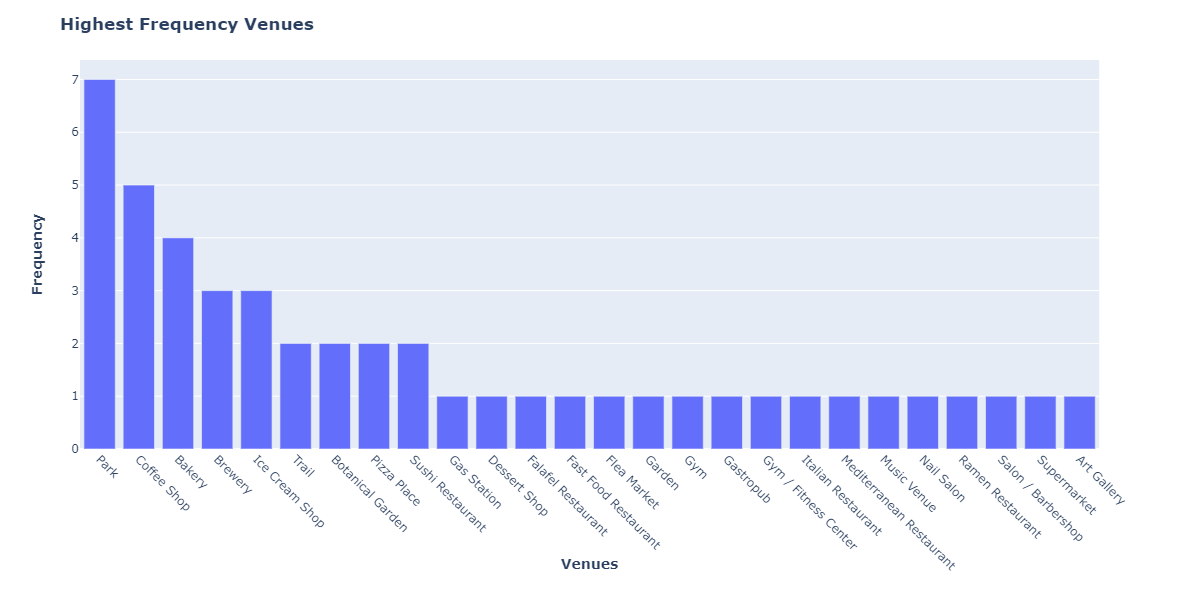

In [55]:
trail_venues[trail_venues['Venue Category'] == 'Bakery']

Neighborhood  Neighborhood Latitude  \
46      8300 E Lawther Dr., Dallas, TX              32.841340   
55      8300 E Lawther Dr., Dallas, TX              32.841340   
70  511 W 22nd St., New York, NY 10011              40.747207   
75  511 W 22nd St., New York, NY 10011              40.747207   

    Neighborhood Longitude                    Venue  Venue Latitude  \
46              -96.714399      Nothing Bundt Cakes       32.832815   
55              -96.714399         Unrefined Bakery       32.845981   
70              -74.004868          Fabrique Bakery       40.740717   
75              -74.004868  Aux Merveilleux de Fred       40.738334   

    Venue Longitude Venue Category  
46       -96.702701         Bakery  
55       -96.710815         Bakery  
70       -74.004722         Bakery  
75       -74.004114         Bakery

In [56]:
trail_venues.to_csv('trail_venues.csv')

In [57]:
trails = trails.iloc[[4,7],:]

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />


### Finally, looking at top venues located by the Atlanta beltline specifically to compare

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
trail_venues_2 = getNearbyVenues(names= trails.Venue,
                                   latitudes= trails['Venue Latitude'],
                                   longitudes= trails['Venue Longitude']
                                  )

Atlanta BeltLine Corridor at Lena St
Atlanta BeltLine Corridor under I-20


In [60]:
trail_venues_2.to_csv('final_venues.csv', index = False)

In [61]:

final_onehot = pd.get_dummies(trail_venues_2[['Venue Category']], prefix="", prefix_sep="")


final_onehot['Zipcode'] = trail_venues_2['Neighborhood'] 


final_grouped = final_onehot.groupby('Zipcode').sum().reset_index()

In [62]:


num_top_venues = 10
venue = []
freq = []
zipcode = []


for hood in final_grouped['Zipcode']:
    print("----"+hood+"----")
    temp = final_grouped[final_grouped['Zipcode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp['zipcode'] = hood
    g_data = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    for i in g_data.venue.values:
        venue.append(i)
    for i in g_data.freq.values:
        freq.append(i)
    for i in g_data.zipcode.values:
        zipcode.append(i)
    
   
    
top_ten_venues = pd.DataFrame()
top_ten_venues['Zipcode'] = zipcode
top_ten_venues['Venues'] = venue
top_ten_venues['Freq'] = freq

----Atlanta BeltLine Corridor at Lena St----
----Atlanta BeltLine Corridor under I-20----


In [63]:
top_ten_grouped = top_ten_venues.groupby('Venues')['Freq'].sum().sort_values(ascending = False).reset_index()
fig = px.bar(top_ten_grouped, x = 'Venues', y = 'Freq')

fig.update_layout(title = '<b>Highest Frequency Venues</b>', width = 1200)
fig.update_xaxes(title = '<b>Venues</b>',tickangle = 45)
fig.update_yaxes(title = '<b>Frequency</b>')

fig.show()

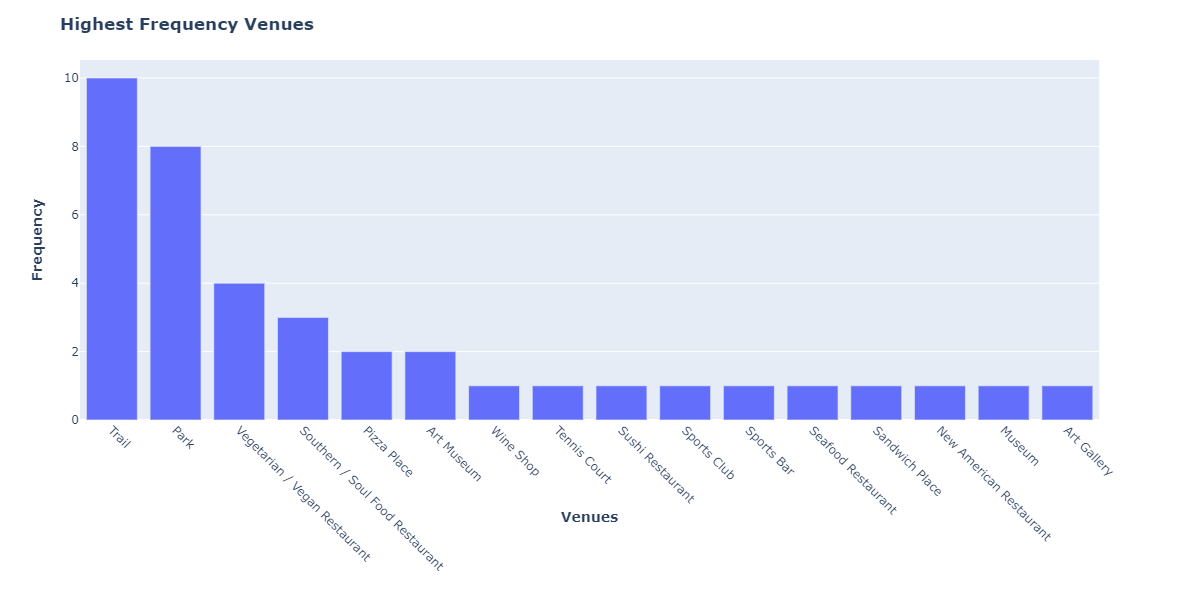

<br />
<br />
<br />
<br />
<br />

# Results

The results of our analysis show that the trail system found in west Atlanta is a key interest point. It is the most prominent feature in foursquare API. What is more, we can see that other large cities have similar trail systems. Because of the recency of the Atlanta housing market boom, the venues of other large metro area trail systems are very different. The most popular types of venues within 2 miles of the trail systems in other major cities are: Ice Cream Shops, Breweries, Coffee Shops, and Bakeries. 

<br />
<br />

### Further Discussion 

It was interesting to note that all of fastest gorwing value homes are all in southwest Atlanta. Being from Atlanta, one would not think this to be the case. However, it is clear that the Atlanta beltline, which started on the eastside of town, is now making its way to the westside. It has made a monumental impact on the eastside economy and further analysis on the store fronts in eastside zip codes would be interseting to show what is available. In zip code 30310, this had the most prominant value increase. This is also the zipcode where the westside beltline is found.

# Conclusion 

Looking at the venue area data from the top most gentrifying zip codes in Atlanta, it is clear that there is an opportunity in the vast Westside Atlanta Beltline area for small business. Right now is an opportunity for a savvy investor to purchase property close to or on the Westside Atlanta Beltline, open a brewery, coffee shop, ice cream shop, or bakery because people love to eat before, during, or after walks, as the data shows!